# Import supporting package

In [3]:
import lmfit
import xarray as xr
import pandas as pd
import numpy as np
import copy

import glob

import xrft
import finufft

from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath

from datetime import datetime

import matplotlib.pyplot as plt

#test
plt.rcParams['font.size'] = 18

from scipy.ndimage import gaussian_filter
import matplotlib as mpl
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)

from DataContainer.ReadData import read_hdf5_file, read_hdf5_global, read_hdf5_run_time, read_csv_file
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from Analyser.FitAnalyser import ThomasFermi2dModel, DensityProfileBEC2dModel, Polylog22dModel
from Analyser.FFTAnalyser import fft, ifft, fft_nutou
from ToolFunction.ToolFunction import *

import time

from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

imageAnalyser = ImageAnalyser()



In [23]:
# get center of thresholded image
def calc_thresh(data):
    shape = np.shape(data)
    thresh = np.zeros(shape)
    sigma = 0.4

    if len(shape) == 4:
        blurred = gaussian_filter(data, sigma=sigma)
        for i in range(0,shape[0]):
            for j in range(0, shape[1]):
                thresh[i,j] = np.where(blurred[i,j] < np.max(blurred[i,j])*0.3,0,1)

    elif len(shape) == 3:
        blurred = gaussian_filter(data, sigma=sigma)
        for i in range(0,shape[0]):
                thresh[i] = np.where(blurred[i] < np.max(blurred[i])*0.3,0,1)

    else:
        print("Shape of data is wrong, output is empty")

    return thresh

def calc_cen(thresh1):
    """
    returns array: [Y_center,X_center]
    """
    cen = np.zeros(2)
    (Y,X) = np.shape(thresh1)


    thresh1 = thresh1 /np.sum(thresh1)

    # marginal distributions
    dx = np.sum(thresh1, 0)
    dy = np.sum(thresh1, 1)

    # expected values
    cen[0] = np.sum(dx * np.arange(X))
    cen[1] = np.sum(dy * np.arange(Y))
    return cen

def calc_cen_bulk(thresh):
    """
    returns array in shape of input, containing array with [Y_center,X_center] for each image
    """
    shape = np.shape(thresh)
    cen = np.zeros((shape[0], shape[1], 2))
    for i in range(0, shape[0]):
        for j in range(0, shape[1]):
            cen[i,j] = calc_cen(thresh[i,j])
    return cen

def guess_BEC_width(thresh, center):
    """
    returns width of thresholded area along both axis through the center with shape of thresh and [X_width, Y_width] for each image
    """
    shape = np.shape(thresh)
    BEC_width_guess = np.zeros((shape[0], shape[1], 2))

    for i in range(0, shape[0]):
        for j in range(0, shape[1]):
            BEC_width_guess[i, j, 0] = np.sum(thresh[i, j, round(center[i,j,1]), :])
            BEC_width_guess[i, j, 1] = np.sum(thresh[i, j, :, round(center[i,j,0])])

    return BEC_width_guess



def gaussian(x, x0, sigma, A):
    return A * np.exp(-0.5 * (x-x0)**2 / sigma**2)

# def polylog(power, numerator, order = 15):
#
#     dataShape = numerator.shape
#     numerator = np.tile(numerator, (order, 1))
#     numerator = np.power(numerator.T, np.arange(1, order+1)).T
#
#     denominator = np.arange(1, order+1)
#     denominator = np.tile(denominator, (dataShape[0], 1))
#     denominator = denominator.T
#
#     data = numerator/ np.power(denominator, power)
#
#     return np.sum(data, axis=0)

def polylog_tab(pow, x):
    order = 100
    sum = 0
    for k in range(1,order):
        sum  += x ** k /k **pow
    return sum

x_int = np.linspace(0, 1.00001, 100000)

poly_tab = polylog_tab(2,x_int)



polylog_int = CubicSpline(x_int, poly_tab)

def thermal(x, x0, amp, sigma):
    res = np.exp(-0.5 * (x-x0)**2 / sigma**2)
    return amp/1.643 * polylog_int(res)

def Thomas_Fermi_1d(x, x0, amp, sigma):
    res = (1- ((x-x0)/sigma)**2)
    res = np.where(res > 0, res, 0)
    res = res**(3/2)
    return amp * res

def density_1d(x, x0_bec, x0_th, amp_bec, amp_th, sigma_bec, sigma_th):
    return thermal(x, x0_th, amp_th, sigma_th) + Thomas_Fermi_1d(x, x0_bec, amp_bec, sigma_bec)


def polylog(pow, x):
    order = 15
    sum = 0
    for k in range(1,order):
        sum  += x ** k /k **pow
    return sum


def ThomasFermi_2d(x, y=0.0, centerx=0.0, centery=0.0, amplitude=1.0, sigmax=1.0, sigmay=1.0):

    res = (1- ((x-centerx)/(sigmax))**2 - ((y-centery)/(sigmay))**2)
    res = np.where(res > 0, res, 0)
    res = res**(3/2)
    return amplitude * res
    # return amplitude * 5 / 2 / np.pi / max(tiny, sigmax * sigmay) * np.where(res > 0, res, 0)


    # return amplitude / 2 / np.pi / 1.20206 / max(tiny, sigmax * sigmay) * polylog(2, np.exp( -((x-centerx)**2/(2 * (sigmax)**2))-((y-centery)**2/( 2 * (sigmay)**2)) ))
# Set up table for polylog


def polylog2_2d(x, y=0.0, centerx=0.0, centery=0.0, amplitude=1.0, sigmax=1.0, sigmay=1.0):
    ## Approximation of the polylog function with 2D gaussian as argument. -> discribes the thermal part of the cloud
    return amplitude/1.643  * polylog_int(np.exp( -((x-centerx)**2/(2 * sigmax**2))-((y-centery)**2/( 2 * sigmay**2)) ))



def density_profile_BEC_2d(x, y=0.0, amp_bec=1.0, amp_th=1.0, x0_bec=0.0, y0_bec=0.0, x0_th=0.0, y0_th=0.0,
                           sigmax_bec=1.0, sigmay_bec=1.0, sigma_th=1.0):
    return ThomasFermi_2d(x=x, y=y, centerx=x0_bec, centery=y0_bec,
                          amplitude=amp_bec, sigmax=sigmax_bec, sigmay=sigmay_bec
                          ) + polylog2_2d(x=x, y=y, centerx=x0_th, centery=y0_th,
                                          amplitude=amp_th, sigmax=sigma_th,sigmay=sigma_th)

def cond_frac(results):
    bval = results.best_values
    tf_fit = ThomasFermi_2d(X,Y,centerx=bval['x0_bec'], centery=bval['y0_bec'], amplitude=bval['amp_bec'], sigmax=bval['sigmax_bec'], sigmay=bval['sigmay_bec'])
    N_bec = np.sum(tf_fit)
    fit = density_profile_BEC_2d(X,Y, **bval)
    N_ges = np.sum(fit)
    return N_bec/N_ges

def print_bval(res_s):
    keys = res_s.best_values.keys()
    bval = res_s.best_values
    init = res_s.init_params

    for item in keys:
        print(f'{item}: {bval[item]:.3f}, (init = {init[item].value:.3f}), bounds = [{init[item].min:.2f} : {init[item].max :.2f}] ')
    print('')

def print_bval_bulk(res_):
    shape = np.shape(res_)
    if len(shape) == 2:
        for i in range(shape[0]):
            for j in range(shape[1]):
                print(f'image: {i}, {j}')
                print_bval(res_[i][j])

    if len(shape) == 1:
        for i in range(shape[0]):
            print(f'image: {i}')
            print_bval(res_[i])


In [5]:
img_dir = '//DyLabNAS/Data/'
SequenceName = "Evaporative_Cooling" + "/"
folderPath = img_dir + SequenceName + '2023/04/17'# get_date()


shotNum = "import"
filePath = folderPath + "/" + shotNum + "/*.h5"

In [6]:

dataSet = read_hdf5_file(filePath, "images/MOT_3D_Camera/in_situ_absorption")
# flip the x and y axis
dataSet = swap_xy(dataSet)

# get the scan axis name of the shot
scanAxis = get_scanAxis(dataSet)

# calculate the absorption imaging
dataSet = imageAnalyser.get_absorption_images(dataSet)

OD = dataSet["OD"]

OD_np = OD.to_numpy()

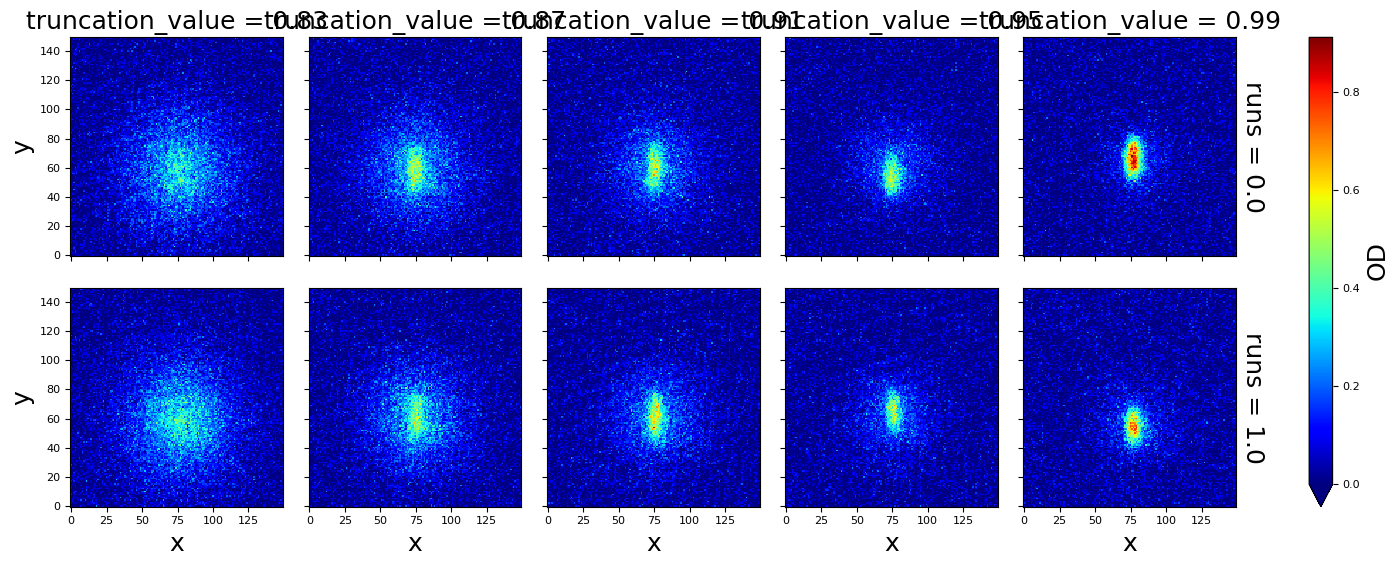

In [12]:
imageAnalyser.center = (960, 890)
imageAnalyser.span = (150, 150)
imageAnalyser.fraction = (0.1, 0.1)

dataSet_cropOD = imageAnalyser.crop_image(dataSet.OD)
dataSet_cropOD = imageAnalyser.substract_offset(dataSet_cropOD).load()
cropOD = dataSet_cropOD.to_numpy()
dataSet_cropOD.plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[0], row=scanAxis[1])
plt.show()

In [11]:
data = OD_np
cut_width = 250
thresh = calc_thresh(data)
center = calc_cen_bulk(thresh)

shape = np.shape(data)
cropOD = np.zeros((shape[0], shape[1], cut_width, cut_width))
blurred = gaussian_filter(data, sigma=1.7)

for i in range(0,shape[0]):
    for j in range(0, shape[1]):
        amax = np.argmax(blurred[i,j])

        center[i,j] = np.unravel_index(amax, (shape[2], shape[3]))
        print(center[i,j])
        print(np.max(data[i,j]))
        print(data[i,j, round(center[i,j,0]), round(center[i,j,1]) ])
        cropOD[i,j] = data[i,j, round(center[i,j,0]-cut_width/2):round(center[i,j,0]+cut_width/2), round(center[i,j,1]-cut_width/2):round(center[i,j,1]+cut_width/2)]

thresh = calc_thresh(cropOD)
center = calc_cen_bulk(thresh)
# print(center)
BEC_width_guess = guess_BEC_width(thresh, center)


[875. 961.]
1.3862943611198906
0.3848458209054287
[875. 961.]
1.0986122886681098
0.5059356384717989
[875. 961.]
0.916290731874155
0.46357273891544515
[876. 962.]
0.706570200892086
0.37729423114146804
[876. 962.]
0.9019019944220554
0.750305594399894
[875. 961.]
0.6931471805599453
0.3483066942682157
[875. 961.]
1.3862943611198906
0.5520685823000397
[875. 961.]
0.842678914530909
0.5671064596645803
[876. 962.]
0.706570200892086
0.5768873744440833
[876. 962.]
0.916290731874155
0.5596157879354228


In [226]:
print(BEC_width_guess)


[[[19. 15.]
  [19. 18.]
  [24. 20.]
  [26. 23.]
  [26. 19.]
  [28. 23.]
  [26. 22.]
  [26. 25.]
  [25. 22.]
  [25. 20.]
  [30. 25.]]

 [[ 5.  3.]
  [ 9.  5.]
  [ 7.  9.]
  [10.  4.]
  [15. 13.]
  [22. 17.]
  [15. 15.]
  [ 7.  4.]
  [13. 12.]
  [19. 15.]
  [14. 12.]]]


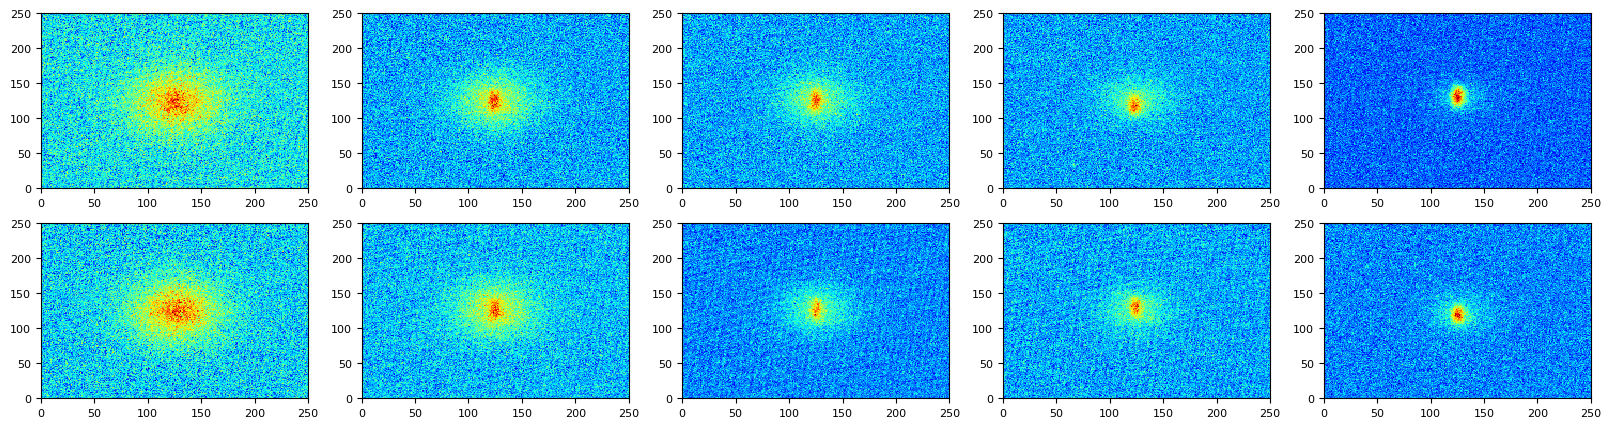

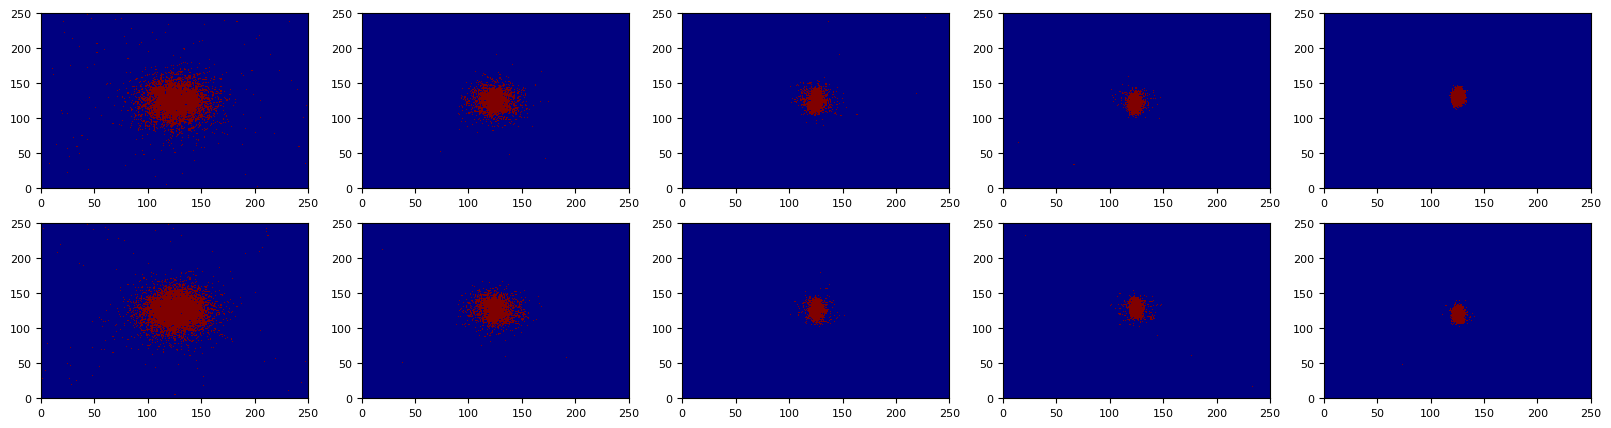

In [12]:
fig, ax = plt.subplots(shape[0],shape[1], figsize=(20,5))

for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        ax[i,j].pcolormesh(cropOD[i,j], cmap='jet',shading='auto')
        #ax[i,j].plot(center[i,j,0], center[i,j,1], markersize=12, marker='x')
plt.show()

fig, ax = plt.subplots(shape[0],shape[1], figsize=(20,5))

for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        ax[i,j].pcolormesh(thresh[i,j], cmap='jet')
plt.show()


In [43]:
# from opencv import moments
start = time.time()
shape = np.shape(cropOD)
sigma = 0.4
blurred = gaussian_filter(cropOD, sigma=sigma)

thresh = np.zeros(shape)
for i in range(0,shape[0]):
    for j in range(0, shape[1]):
        thresh[i,j] = np.where(blurred[i,j] < np.max(blurred[i,j])*0.5,0,1)

center = calc_cen_bulk(thresh)

BEC_width_guess = guess_BEC_width(thresh, center)

X_guess_og = np.zeros((shape[0], shape[1], shape[3]))
# Y_guess_og = np.zeros((shape[0], shape[1], shape[2]))

for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        X_guess_og[i,j] = np.sum(cropOD[i,j,round(center[i,j,1] - BEC_width_guess[i,j,1]/2) : round(center[i,j,1] + BEC_width_guess[i,j,1]/2) , :], 0) / len(cropOD[i,j,round(center[i,j,1] - BEC_width_guess[i,j,1]/2) : round(center[i,j,1] + BEC_width_guess[i,j,1]/2),0])

        # Y_guess_og[i,j] = np.sum(cropOD[i,j, :, round(center[i,j,0] - BEC_width_guess[i,j,0]/2) : round(center[i,j,0] + BEC_width_guess[i,j,0]/2)], 1) / len(cropOD[i,j,0,round(center[i,j,0] - BEC_width_guess[i,j,0]/2) : round(center[i,j,0] + BEC_width_guess[i,j,0]/2)])

#[nr images x, nr images y, X / Y, center / sigma]
x = np.linspace(0,shape[3],shape[3])
y = np.linspace(0,shape[2], shape[2])

popt = np.zeros((shape[0], shape[1], 6))

p0 = np.ones((shape[0], shape[1], 6))

max = np.zeros((shape[0], shape[1]))

for i in range(0, shape[0]):
    max[i] = np.ndarray.max(X_guess_og[i],axis=1)

# Fitting x without math constr
fitmodel = lmfit.Model(density_1d,independent_vars=['x'])

result_x = []

for i in range(0, shape[0]):
    temp_res = []
    for j in range(0, shape[1]):
        t1 = time.time()
        params = lmfit.Parameters()
        params.add_many(
            ('x0_bec', center[i,j,0], True,0, 200),
            ('x0_th',center[i,j,0], True,0, 200),
            ('amp_bec', 0.7 * max[i,j], True, 0, 1.3 * np.max(X_guess_og[i,j])),
            ('amp_th', 0.3 * max[i,j], True, 0, 1.3 * np.max(X_guess_og[i,j])),
            ('deltax', 70, True, 0,150),
            ('sigma_bec',BEC_width_guess[i,j,0]/1.22, True, 0, 50)
        )
        params.add('sigma_th', 3*BEC_width_guess[i,j,0], min=0, expr=f'0.632*sigma_bec + 0.518*deltax')

        # params.add('sigma_th', 3*BEC_width_guess[i,j,0], True, min=0,max=150)
        t2 = time.time()
        res = fitmodel.fit(X_guess_og[i,j], x=x, params=params)
        t3 = time.time()
        temp_res.append(res)
        t4 = time.time()
        # print(t2 - t1)
        # print(t3 - t2)
        # print(t4 - t3)
        # print("")
        lmfit.report_fit(res)

        print()
    result_x.append(temp_res)
stop = time.time()

print(f'total time: {(stop-start)*1e3} ms')

C:\Users\Jianshun Gao\AppData\Local\Temp\ipykernel_15584\2817508691.py:91: RuntimeWarning: invalid value encountered in power
  res = (1-(( x - x0 ) / sigma) **2) **(3/2)


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 94
    # data points      = 200
    # variables        = 6
    chi-square         = 0.02547745
    reduced chi-square = 1.3133e-04
    Akaike info crit   = -1781.65579
    Bayesian info crit = -1761.86588
    R-squared          = 0.98666724
[[Variables]]
    x0_bec:     101.124647 +/- 0.79071563 (0.78%) (init = 101.8194)
    x0_th:      102.711004 +/- 0.24982699 (0.24%) (init = 101.8194)
    amp_bec:    0.03110320 +/- 0.00530709 (17.06%) (init = 0.2253557)
    amp_th:     0.28871096 +/- 0.00350675 (1.21%) (init = 0.09658102)
    deltax:     50.4263791 +/- 1.73159941 (3.43%) (init = 70)
    sigma_bec:  10.3009445 +/- 1.47976427 (14.37%) (init = 23.77049)
    sigma_th:   32.6310613 +/- 0.37432681 (1.15%) == '0.632*sigma_bec + 0.518*deltax'
[[Correlations]] (unreported correlations are < 0.100)
    C(deltax, sigma_bec) = -0.9174
    C(amp_bec, amp_th)   = -0.5988
    C(amp_th, sigma_bec) = -0.4403
    C(amp_bec, 

In [13]:
# from opencv import moments
start = time.time()

shape = np.shape(cropOD)
thresh = calc_thresh(cropOD)
center = calc_cen_bulk(thresh)
# print(center)
BEC_width_guess = guess_BEC_width(thresh, center)

X_guess_og = np.zeros((shape[0], shape[1], shape[3]))
# Y_guess_og = np.zeros((shape[0], shape[1], shape[2]))

for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        X_guess_og[i,j] = np.sum(cropOD[i,j,round(center[i,j,1] - BEC_width_guess[i,j,1]/2) : round(center[i,j,1] + BEC_width_guess[i,j,1]/2) , :], 0) / len(cropOD[i,j,round(center[i,j,1] - BEC_width_guess[i,j,1]/2) : round(center[i,j,1] + BEC_width_guess[i,j,1]/2),0])

        # Y_guess_og[i,j] = np.sum(cropOD[i,j, :, round(center[i,j,0] - BEC_width_guess[i,j,0]/2) : round(center[i,j,0] + BEC_width_guess[i,j,0]/2)], 1) / len(cropOD[i,j,0,round(center[i,j,0] - BEC_width_guess[i,j,0]/2) : round(center[i,j,0] + BEC_width_guess[i,j,0]/2)])

#[nr images x, nr images y, X / Y, center / sigma]
x = np.linspace(0,shape[3],shape[3])
y = np.linspace(0,shape[2], shape[2])

popt = np.zeros((shape[0], shape[1], 6))

p0 = np.ones((shape[0], shape[1], 6))

max_val = np.zeros((shape[0], shape[1]))

for i in range(0, shape[0]):
    max_val[i] = np.ndarray.max(X_guess_og[i], axis=1)

# Fitting x without math constr
fitmodel = lmfit.Model(density_1d,independent_vars=['x'])

result_x = []

for i in range(0, shape[0]):
    temp_res = []
    for j in range(0, shape[1]):
        t1 = time.time()
        params = lmfit.Parameters()
        params.add_many(
            ('x0_bec', center[i,j,0], True,0, 200),
            ('x0_th',center[i,j,0], True,0, 200),
            ('amp_bec', 0.7 * max_val[i,j], True, 0, 1.3 * np.max(X_guess_og[i,j])),
            ('amp_th', 0.3 * max_val[i,j], True, 0, 1.3 * np.max(X_guess_og[i,j])),
            ('deltax', 3*BEC_width_guess[i,j,0], True, 0,cut_width),
            # ('sigma_bec',BEC_width_guess[i,j,0]/1.22, True, 0, 50)
            ('sigma_bec',BEC_width_guess[i,j,0]/1.22, True, 0, 50)
        )
        params.add('sigma_th', 3*BEC_width_guess[i,j,0], min=0, expr=f'0.632*sigma_bec + 0.518*deltax')

        # params.add('sigma_th', 3*BEC_width_guess[i,j,0], True, min=0,max=150)
        t2 = time.time()
        res = fitmodel.fit(X_guess_og[i,j], x=x, params=params)
        t3 = time.time()
        temp_res.append(res)
        t4 = time.time()
        # print(t2 - t1)
        # print(t3 - t2)
        # print(t4 - t3)
        # print("")
        print(f'image {i}, {j}')
        lmfit.report_fit(res)
        print()

        print()
    result_x.append(temp_res)
stop = time.time()

print(f'total time: {(stop-start)*1e3} ms')

C:\Users\Jianshun Gao\AppData\Local\Temp\ipykernel_30284\141522514.py:91: RuntimeWarning: invalid value encountered in power
  res = (1-(( x - x0 ) / sigma) **2) **(3/2)


image 0, 0
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 143
    # data points      = 250
    # variables        = 6
    chi-square         = 0.02046362
    reduced chi-square = 8.3867e-05
    Akaike info crit   = -2340.64189
    Bayesian info crit = -2319.51313
    R-squared          = 0.98804264
[[Variables]]
    x0_bec:     118.969515 +/- 1.9798e+10 (16640885617.16%) (init = 125.2444)
    x0_th:      126.291765 +/- 0.46890175 (0.37%) (init = 125.2444)
    amp_bec:    5.0309e-13 +/- 0.00535605 (1064634965786.03%) (init = 0.1857203)
    amp_th:     0.25828629 +/- 0.01294854 (5.01%) (init = 0.0795944)
    deltax:     1.67647827 +/- 152948.188 (9123183.47%) (init = 183)
    sigma_bec:  49.9995295 +/- 8259069.00 (16518293.43%) (init = 50)
    sigma_th:   32.4681184 +/- 5298958.79 (16320498.53%) == '0.632*sigma_bec + 0.518*deltax'
[[Correlations]] (unreported correlations are < 0.100)
    C(deltax, sigma_bec)  = +1.0000
    C(amp_bec, amp_th)    = +0.9874
  

In [1]:
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        print(result_x[i][j].best_values)

NameError: name 'shape' is not defined

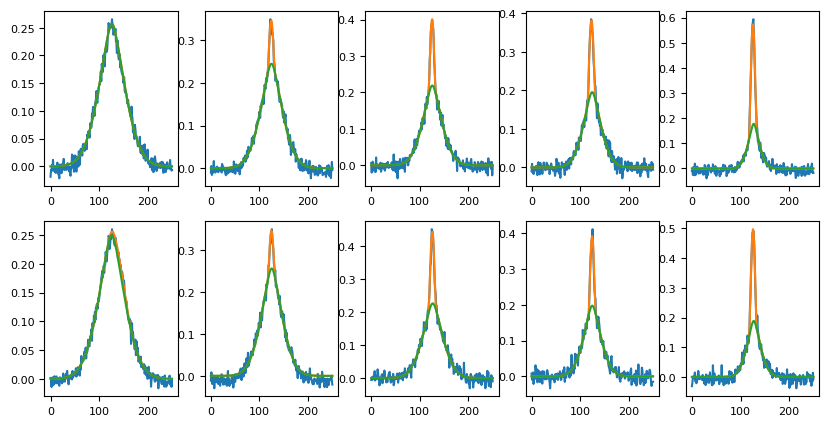

In [25]:
fsize= (10,5)
fig, ax = plt.subplots(shape[0],shape[1],figsize=fsize)
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        #lab = f"A$_{{BEC}}$ = {popt[i,j,0]:.1f} \n A$_{{th}}$ = {popt[i,j,1]:.1f} "
        bval = result_x[i][j].best_values
        ax[i,j].plot(x, X_guess_og[i,j])
        ax[i,j].plot(x, density_1d(x, **result_x[i][j].best_values))
        ax[i,j].plot(x, thermal(x, bval['x0_th'], bval['amp_th'], bval['sigma_th']))


plt.show()

## 2D Fit without mathematical constraint

In [64]:

result = []
times = []
x = np.linspace(0,shape[3],cut_width)
y = np.linspace(0,shape[2], cut_width)

for i in range(0,shape[0]):
    temp_res_arr = []
    for j in range(0,shape[1]):
        print(f'image {i},{j}')
        data = cropOD[i,j]
        fitModel = lmfit.Model(density_profile_BEC_2d, independent_vars=['x','y'])
        #fitModel.set_param_hint('deltax', value=5)

        bval_1d = result_x[i][j].best_values
        S = np.max(blurred[i,j])/(bval_1d['amp_bec'] + bval_1d['amp_th'])

        params = lmfit.Parameters()
        #print(bval['sigma_th'])
        params.add_many(
            ('amp_bec', S * bval_1d['amp_bec'], True, 0, 1.3 * np.max(data)),
            ('amp_th',S * bval_1d['amp_th'], True, 0, 1.3 * np.max(data)),
            ('x0_bec',center[i,j,0], True, 0, 150),
            ('y0_bec',center[i,j,1], True, 0, 150),
            ('x0_th',center[i,j,0], True, 0, 150),
            ('y0_th',center[i,j,1], True, 0, 150),
            ('sigmax_bec',bval_1d['sigma_bec'], True, 0, 100),
            ('sigmay_bec',BEC_width_guess[i,j,1], True, 0, 100),
            ('sigma_th',bval_1d['sigma_th'], True, 0, 50)
        )

        X,Y = np.meshgrid(x, y)
        X_1d = X.flatten()
        Y_1d = Y.flatten()

        data1d = data.flatten()
        start = time.time()
        res = fitModel.fit(data1d, x=X_1d, y=Y_1d, params=params)
        stop = time.time()


        # Check if there is an thermal part
        bval = res.best_values
        sigma_cut = max(bval['sigmay_bec'],bval['sigmax_bec'])
        tf_fit = ThomasFermi_2d(X,Y,centerx=bval['x0_bec'], centery=bval['y0_bec'], amplitude=bval['amp_bec'], sigmax=bval['sigmax_bec'], sigmay=bval['sigmay_bec'])
        tf_fit_2 = ThomasFermi_2d(X,Y,centerx=bval['x0_bec'], centery=bval['y0_bec'], amplitude=bval['amp_bec'], sigmax=1.5 * sigma_cut, sigmay=1.5*sigma_cut)


        mask = np.where(tf_fit > 0, np.nan, data)
        #mask[i,j] = gaussian_filter(mask[i,j], sigma = 0.4)
        mask = np.where(tf_fit_2 > 0, mask, np.nan)

        check_value = np.nansum(mask)

        print(stop-start)

        # if (check_value < 45) or ((check_value > 200) and (bval['sigma_th'] < min(bval['sigmax_bec'], bval['sigmay_bec']))):
        #     print('No thermal part detected, performing fit without thermal function')
        #     if check_value > 200:
        #         print('Sigma Thermal smaller than BEC, but still strong part around masked region --> BEC guessed wrong')
        #
        #     params = lmfit.Parameters()
        #     #print(bval['sigma_th'])
        #     params.add_many(
        #         ('amp_bec', S * bval_1d['amp_bec'], True, 0, 1.3 * np.max(data)),
        #         ('amp_th',0, False, 0, 1.3 * np.max(data)),
        #         ('x0_bec',center[i,j,0], True, 0, 150),
        #         ('y0_bec',center[i,j,1], True, 0, 150),
        #         ('x0_th', 1, False, 0, 150),
        #         ('y0_th', 1, False, 0, 150),
        #         ('sigmax_bec',bval_1d['sigma_bec'], True, 0, 50),
        #         ('sigmay_bec',BEC_width_guess[i,j,1], True, 0, 50),
        #         ('sigma_th',1, False, 0, 50)
        #     )
        #
        #     start2 = time.time()
        #     res = fitModel.fit(data1d, x=X_1d, y=Y_1d, params=params)
        #     stop2 = time.time()
        #
        #     print(stop2-start2)
        #     print('')
        stop2 = time.time()



        times.append(stop2-start)
        temp_res_arr.append(res)
    result.append(temp_res_arr)
times = np.array(times)
print(f"fitting time = {np.mean(times)} +- {np.std(times, ddof=1)}")
print(times)



image 0,0


C:\Users\Jianshun Gao\AppData\Local\Temp\ipykernel_15584\686923892.py:107: RuntimeWarning: invalid value encountered in power
  res = (1- ((x-centerx)/(sigmax))**2 - ((y-centery)/(sigmay))**2)**(3 / 2)


2.446171998977661
image 0,1
0.42479395866394043
image 0,2
0.3388192653656006
image 0,3
1.0576553344726562
image 0,4
0.4093611240386963
image 1,0
1.2626025676727295
image 1,1
0.5342316627502441
image 1,2
0.40906715393066406
image 1,3
0.4411289691925049
image 1,4
0.33938121795654297
fitting time = 0.7710072994232178 +- 0.670787745643047
[2.45115781 0.42978144 0.34380507 1.06264186 0.41334987 1.26659203
 0.53821802 0.41405177 0.44610786 0.34436727]


In [15]:

result = []
result_1 = []
times = []
x = np.linspace(0,shape[3],cut_width)
y = np.linspace(0,shape[2], cut_width)

fitModel = lmfit.Model(density_profile_BEC_2d, independent_vars=['x','y'])

for i in range(0,shape[0]):
    temp_res_arr = []
    temp_res_arr_1 = []
    for j in range(0,shape[1]):
        print()
        print(f'image {i},{j}')
        data = cropOD[i,j]

        #fitModel.set_param_hint('deltax', value=5)

        bval_1d = result_x[i][j].best_values
        S = np.max(gaussian_filter(data, sigma=1))/(bval_1d['amp_bec'] + bval_1d['amp_th'])
        params = lmfit.Parameters()
        #print(bval['sigma_th'])
        do_fit_2 = True
        if bval_1d['amp_th']/bval_1d['amp_bec'] > 4:
            print('Image seems to be purely thermal (guessed from 1d fit amplitude)')
            do_fit_2 = False
            params.add_many(
                ('amp_bec', 0, False, 0, 1.3 * np.max(data)),
                ('amp_th',S * bval_1d['amp_th'], True, 0, 1.3 * np.max(data)),
                ('x0_bec',1, False),
                ('y0_bec',1, False),
                ('x0_th',center[i,j,0], True, center[i,j,0] -10, center[i,j,0] + 10),
                ('y0_th',center[i,j,1], True, center[i,j,1] -10, center[i,j,1] + 10),
                ('sigmax_bec', 1, False),
                ('sigmay_bec', 1, False),
                ('sigma_th',bval_1d['sigma_th'], True, 0, cut_width)
            )

        elif bval_1d['amp_bec']/bval_1d['amp_th'] > 10:
            print('Image seems to be pure BEC (guessed from 1d fit amplitude)')
            do_fit_2 = False
            params.add_many(
                ('amp_bec', S * bval_1d['amp_bec'], True, 0, 1.3 * np.max(data)),
                ('amp_th',0, False),
                ('x0_bec',center[i,j,0], True, center[i,j,0] -10, center[i,j,0] + 10),
                ('y0_bec',center[i,j,1], True, center[i,j,1] - 10, center[i,j,1] + 10),
                ('x0_th', 1, False),
                ('y0_th', 1, False),
                ('sigmax_bec',bval_1d['sigma_bec'], True, 0, 2/1.22 * BEC_width_guess[i,j,0]),
                ('sigmay_bec',BEC_width_guess[i,j,1]/1.22, True, 0, 2/1.22 * BEC_width_guess[i,j,0]),
                ('sigma_th',bval_1d['sigma_th'], False, 0, 50)
            )



        else:
            params.add_many(
                ('amp_bec', S * bval_1d['amp_bec'], True, 0, 1.3 * np.max(data)),
                ('amp_th',S * bval_1d['amp_th'], True, 0, 1.3 * np.max(data)),
                ('x0_bec',center[i,j,0], True, center[i,j,0] -10, center[i,j,0] + 10),
                ('y0_bec',center[i,j,1], True, center[i,j,1] -10, center[i,j,1] + 10),
                ('x0_th',center[i,j,0], True, center[i,j,0] -10, center[i,j,0] + 10),
                ('y0_th',center[i,j,1], True, center[i,j,1] -10, center[i,j,1] + 10),
                ('sigmax_bec',bval_1d['sigma_bec'], True, 0, 2/1.22 * BEC_width_guess[i,j,0]),
                ('sigmay_bec',BEC_width_guess[i,j,1]/1.22, True, 0, 2/1.22 * BEC_width_guess[i,j,1]),
                ('sigma_th',bval_1d['sigma_th'], True, 0, cut_width)
            )

        X,Y = np.meshgrid(x, y)
        X_1d = X.flatten()
        Y_1d = Y.flatten()

        data1d = data.flatten()
        start = time.time()
        res = fitModel.fit(data1d, x=X_1d, y=Y_1d, params=params)
        stop = time.time()
        temp_res_arr_1.append(res)


        # Check if there is an thermal part
        bval = res.best_values
        sigma_cut = max(bval['sigmay_bec'], bval['sigmax_bec'])
        tf_fit = ThomasFermi_2d(X,Y,centerx=bval['x0_bec'], centery=bval['y0_bec'], amplitude=bval['amp_bec'], sigmax=bval['sigmax_bec'], sigmay=bval['sigmay_bec'])
        tf_fit_2 = ThomasFermi_2d(X,Y,centerx=bval['x0_bec'], centery=bval['y0_bec'], amplitude=bval['amp_bec'], sigmax=1.5 * sigma_cut, sigmay=1.5*sigma_cut)


        mask = np.where(tf_fit > 0, np.nan, data)
        #mask[i,j] = gaussian_filter(mask[i,j], sigma = 0.4)
        mask = np.where(tf_fit_2 > 0, mask, np.nan)

        check_value = np.nansum(mask)

        print(f'time 1st fit: {stop-start :.3f} s')

        # if (check_value < 45) or ((check_value > 10000) and (bval['sigma_th'] < min(bval['sigmax_bec'], bval['sigmay_bec']))):
        #check_value = 200
        if check_value < 45 and do_fit_2:
            print('No thermal part detected, performing fit without thermal function')
            # if check_value > 200:
            #     print('Sigma Thermal smaller than BEC, but still strong part around masked region --> BEC guessed wrong')

            params = lmfit.Parameters()
            #print(bval['sigma_th'])
            params.add_many(
                ('amp_bec', S * bval_1d['amp_bec'], True, 0, 1.3 * np.max(data)),
                ('amp_th',0, False),
                ('x0_bec',center[i,j,0], True, center[i,j,0] -10, center[i,j,0] + 10),
                ('y0_bec',center[i,j,1], True, center[i,j,1] - 10, center[i,j,1] + 10),
                ('x0_th', 1, False),
                ('y0_th', 1, False),
                ('sigmax_bec',bval_1d['sigma_bec'], True, 0, 2/1.22 * BEC_width_guess[i,j,0]),
                ('sigmay_bec',BEC_width_guess[i,j,1]/1.22, True, 0, 2/1.22 * BEC_width_guess[i,j,0]),
                ('sigma_th',bval_1d['sigma_th'], False, 0, 50)
            )

            start2 = time.time()
            res = fitModel.fit(data1d, x=X_1d, y=Y_1d, params=params)
            stop2 = time.time()

            print(f'time pure bec fit: {stop2-start2 :.3f} s')
            print('')
        stop2 = time.time()



        times.append(stop2-start)
        temp_res_arr.append(res)
    result_1.append(temp_res_arr_1)
    result.append(temp_res_arr)
times = np.array(times)
print(f"fitting time = {np.mean(times):.3f} +- {np.std(times, ddof=1):.3f}")
print(f"max fitting time = {np.max(times) :.3f}s")
print(times)




image 0,0
Image seems to be purely thermal (guessed from 1d fit amplitude)
time 1st fit: 0.229 s

image 0,1
time 1st fit: 0.487 s

image 0,2
time 1st fit: 0.422 s

image 0,3
time 1st fit: 0.969 s

image 0,4
time 1st fit: 0.334 s

image 1,0
Image seems to be purely thermal (guessed from 1d fit amplitude)
time 1st fit: 0.136 s

image 1,1
time 1st fit: 1.682 s

image 1,2
time 1st fit: 0.440 s

image 1,3
time 1st fit: 0.252 s

image 1,4
time 1st fit: 0.359 s
fitting time = 0.534 +- 0.463
max fitting time = 1.685s
[0.23147106 0.49030185 0.42403865 0.97199774 0.33587432 0.13781762
 1.68479657 0.44243336 0.25544643 0.36216903]


## Plotting

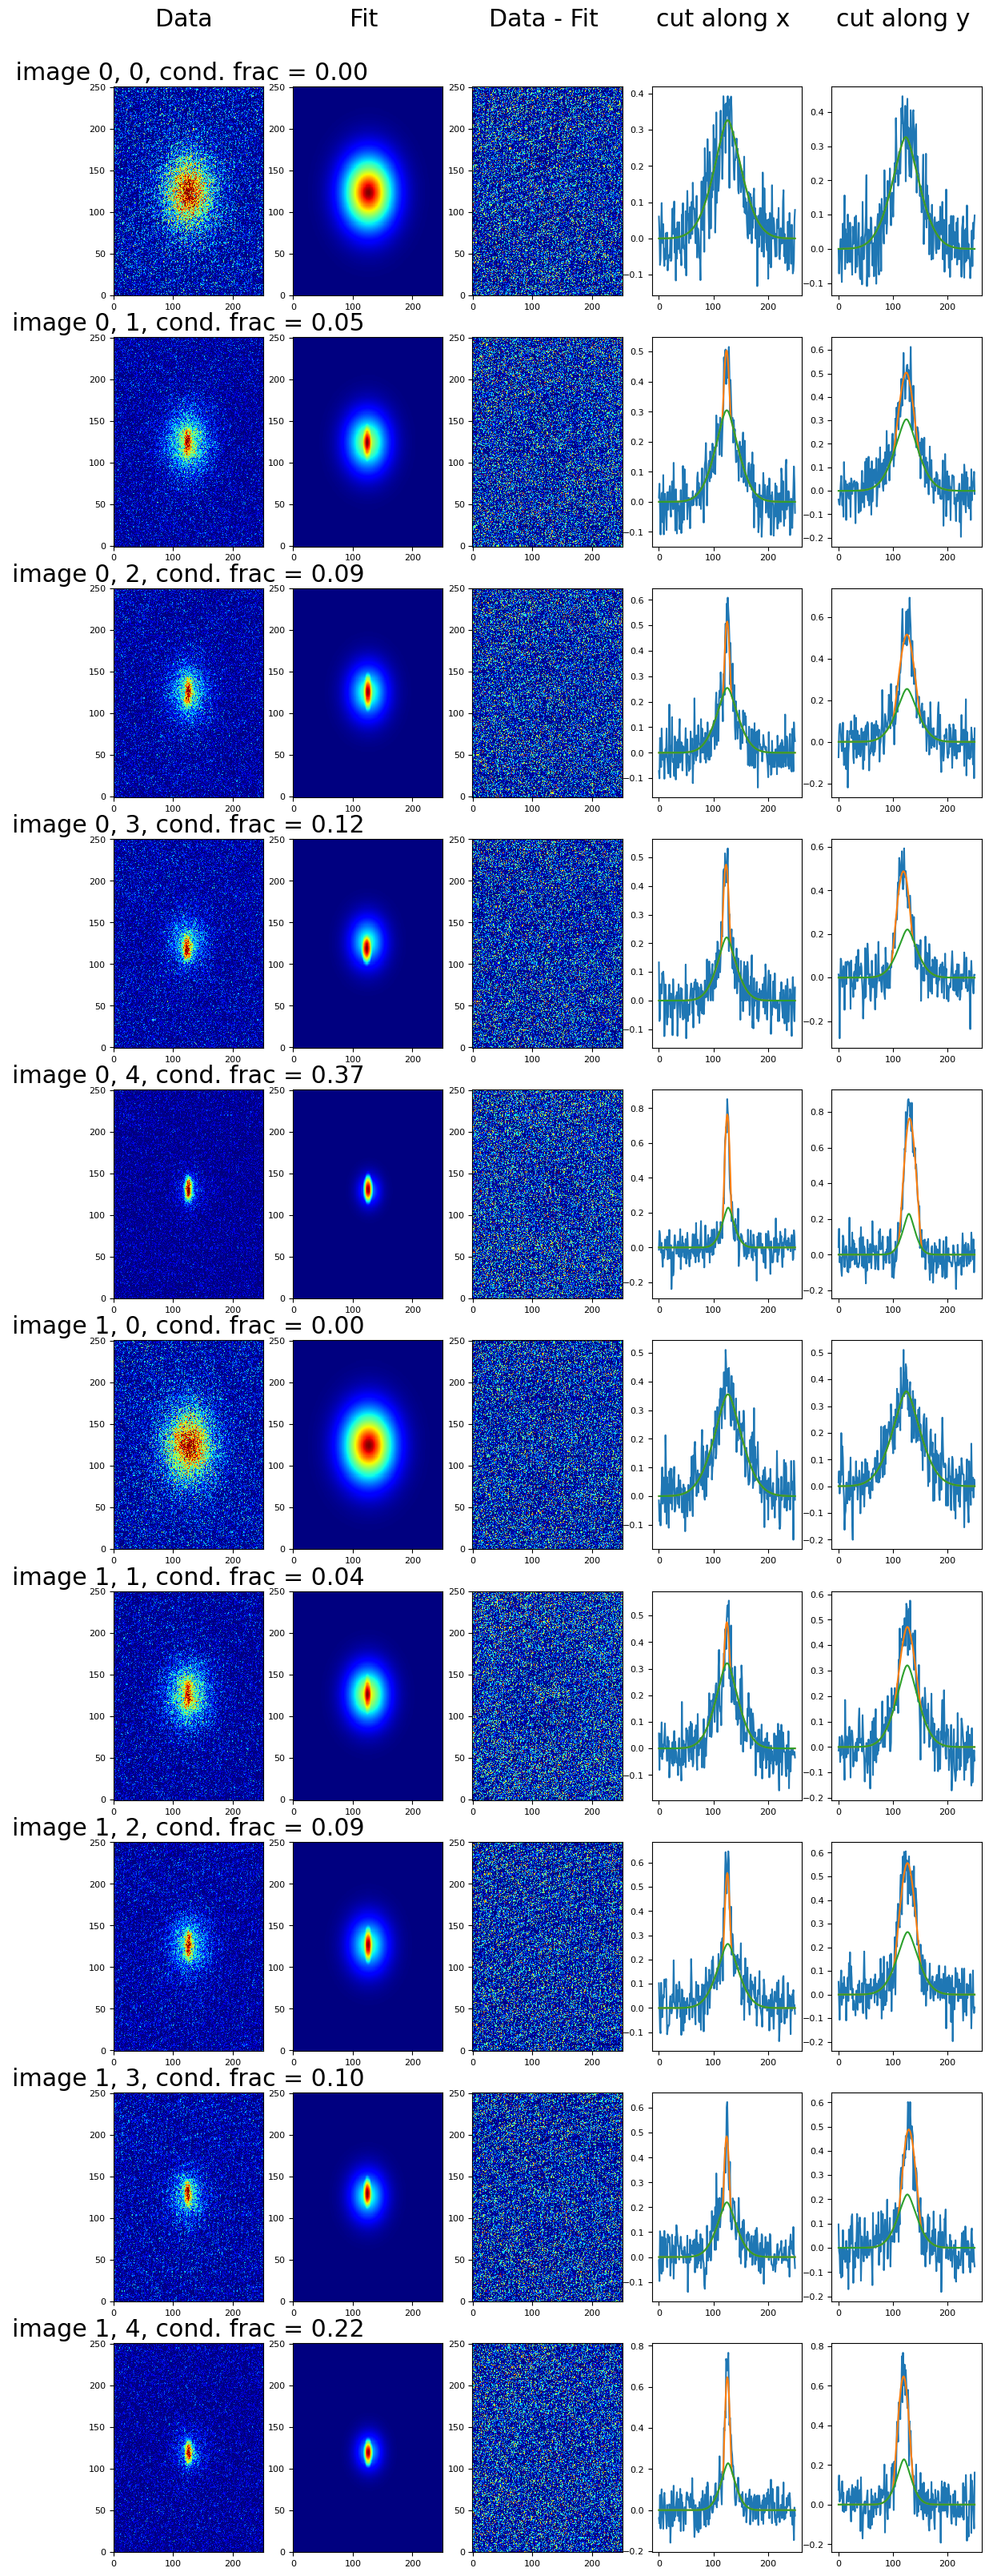

In [26]:
fig, axs = plt.subplots(shape[0] * shape[1], 5, figsize=(14, 4 * shape[0] * shape[1]))

ii = 0
for i in range(0,shape[0]):

    for j in range(0,shape[1]):
        axs[ii,0].set_title(f'image {i}, {j}, cond. frac = {cond_frac(result[i][j]) :.2f}')
        lmfit.fit_report(result[i][j])
        bval = result[i][j].best_values
        fit = density_profile_BEC_2d(X,Y, **bval)
        vmax = np.max(fit)



        ax = axs[ii,0]
        ax.pcolormesh(X, Y, cropOD[i,j], vmin=0, vmax=vmax, cmap='jet', shading='auto')
        #plt.colorbar(art, ax=ax, label='z')


        # Plot gaussian 2d Fit + legend including Width parameters
        ax = axs[ii,1]

        ax.pcolormesh(X, Y, fit, vmin=0, vmax=vmax, cmap='jet', shading='auto')
        #plt.colorbar(art, ax=ax, label='z')

        ax = axs[ii,2]

        ax.pcolormesh(X, Y, fit-cropOD[i,j], vmin=0, vmax=0.2, cmap='jet', shading='auto')


        ax = axs[ii,3]

        ax.plot(x, cropOD[i,j, round(center[i,j,1]), :])
        ax.plot(x, fit[round(center[i,j,1]), :])
        ax.plot(x, thermal(x, bval['x0_th'], bval['amp_th'], bval['sigma_th']))

        ax = axs[ii,4]

        ax.plot(y, cropOD[i,j, :, round(center[i,j,0])])
        ax.plot(y, fit[:, round(center[i,j,0])])
        ax.plot(x, thermal(y, bval['y0_th'], bval['amp_th'], bval['sigma_th']))


        ii += 1

axs[0,0].set_title(f'Data \n \n image {0}, {0}, cond. frac = {cond_frac(result[0][0]) :.2f}')
axs[0,1].set_title('Fit \n \n')
axs[0,2].set_title('Data - Fit \n \n')
axs[0,3].set_title('cut along x \n \n')
axs[0,4].set_title('cut along y \n \n')



plt.show()

In [51]:
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        sx = result[i][j].best_values['sigmax_bec']
        sy = result[i][j].best_values['sigmay_bec']
        s_th = result[i][j].best_values['sigma_th']

        print(f'image {i}, {j}')
        print(min(sx*1.22, sy*1.22))
        print(f'FWHM_x BEC: { sx*1.22:.2f}, FWHM_x thermal: { s_th*1.93:.2f}')
        print(f'FWHM_y BEC: { sy*1.22:.2f}')
        print(f'Ratio fwhm_th/fwhm_bec: { 1/min(sx,sy)/1.22 * s_th *1.93 :.2f}')
        print('')

type: 'sigma_th'

image 0, 0
check val, 996.1322515049512
image 0, 1
check val, 503.70403248392944
image 0, 2
check val, 404.5014209391836
image 0, 3
check val, 204.52155001627648
image 0, 4
check val, 117.05256423462238
image 1, 0
check val, 607.2031498159346
image 1, 1
check val, 569.9239240506499
image 1, 2
check val, 423.4129240784928
image 1, 3
check val, 251.18077589127904
image 1, 4
check val, 151.64045224955777


C:\Users\Jianshun Gao\AppData\Local\Temp\ipykernel_15584\686923892.py:107: RuntimeWarning: invalid value encountered in power
  res = (1- ((x-centerx)/(sigmax))**2 - ((y-centery)/(sigmay))**2)**(3 / 2)


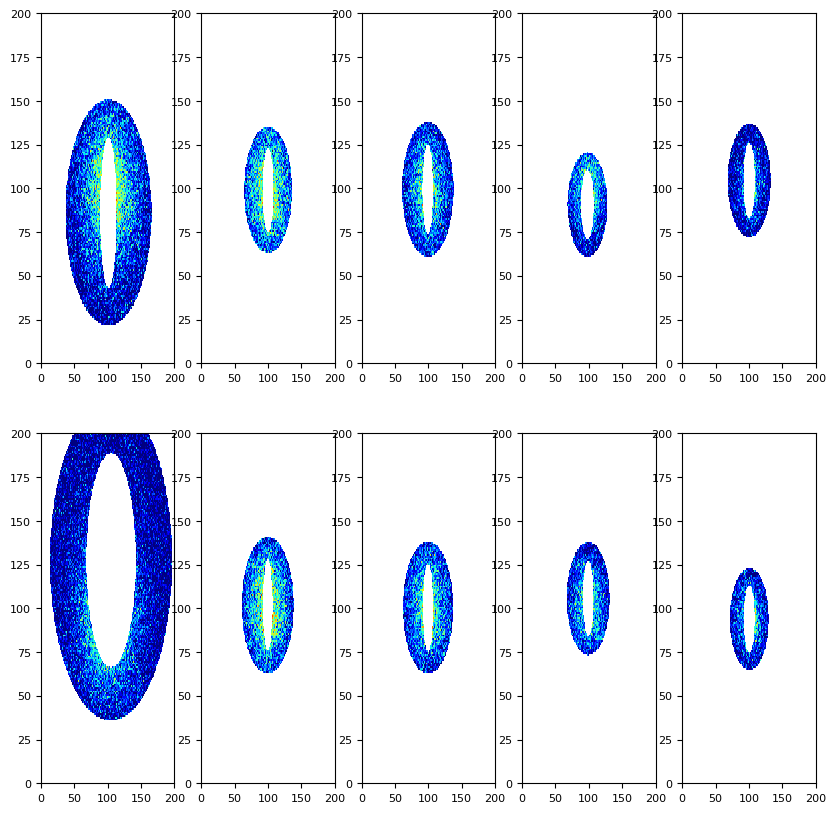

In [68]:

mask = np.zeros(shape)
mask2 = np.zeros(shape)
mask3 = []
fig, ax = plt.subplots(shape[0], shape[1], figsize=(10, 10))

for i in range(0, shape[0]):
    temp_arr = []
    for j in range(0, shape[1]):
        print(f'image {i}, {j}')
        arr = []
        bval = result[i][j].best_values
        sigma_cut = max(bval['sigmay_bec'], bval['sigmax_bec'])
        tf_fit = ThomasFermi_2d(X, Y, centerx=bval['x0_bec'], centery=bval['y0_bec'], amplitude=bval['amp_bec'],
                                sigmax=bval['sigmax_bec'], sigmay=bval['sigmay_bec'])
        tf_fit_2 = ThomasFermi_2d(X, Y, centerx=bval['x0_bec'], centery=bval['y0_bec'], amplitude=bval['amp_bec'],
                                  sigmax=1.5 * sigma_cut, sigmay=1.5 * sigma_cut)

        mask[i, j] = np.where(tf_fit > 0, np.nan, cropOD[i, j])
        #mask[i,j] = gaussian_filter(mask[i,j], sigma = 0.4)
        #mask[i,j] = np.where(tf_fit_2 > 0, mask[i,j], np.nan)
        mask2[i, j] = np.where(tf_fit_2 > 0, mask[i, j], np.nan)
        # print(f'max = {np.nanmax(mask[i,j])}, {np.nanmax(mask[i,j]) / np.nanmin(mask[i,j])}')

        check_value = np.nanmean(mask2[i, j]) / (bval["amp_bec"] + bval["amp_th"])

        print(f'check val, {np.nansum(mask2[i, j])}')

        ax[i, j].pcolormesh(mask2[i, j], cmap='jet', vmin=0, vmax=0.5)

plt.show()

In [66]:
result[1][0]

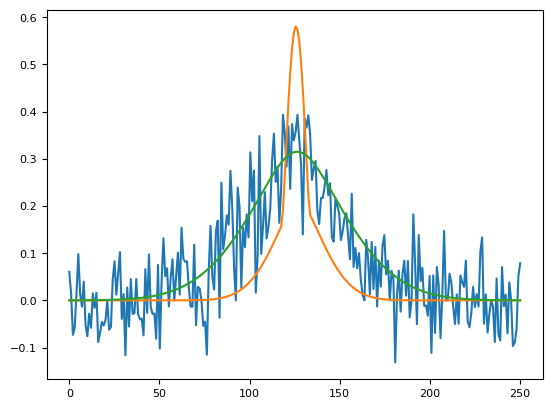

In [19]:
i = 0
j = 0
bval = result[i][j].best_values
plt.plot(x, cropOD[i,j, round(center[i,j,1]), :])
plt.plot(x, fit[round(center[i,j,1]), :])
plt.plot(x, thermal(x, bval['x0_th'], bval['amp_th'], bval['sigma_th']))